In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
            # print(os.path.join(dirname, filename))
            
print("Selesai Import Folder", dirname)       

Selesai Import Folder /kaggle/input/fruits-classification/Fruits Classification/train/Mango


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
train_data = datasets.ImageFolder('/kaggle/input/fruits-classification/Fruits Classification/train', transform=train_transforms)
val_data   = datasets.ImageFolder('/kaggle/input/fruits-classification/Fruits Classification/valid', transform=val_test_transforms)
test_data  = datasets.ImageFolder('/kaggle/input/fruits-classification/Fruits Classification/test', transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

# Get class names
class_names = train_data.classes
print("Classes:", class_names)

# train_size = int(0.8 * len(full_data))
# val_size = len(full_data) - train_size

# Random split
# train_data, val_data = random_split(full_data, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [4]:
from collections import Counter

# Helper function to count class occurrences
def count_class_distribution(dataset):
    class_indices = dataset.targets
    class_counts = Counter(class_indices)
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

    return {idx_to_class[idx]: count for idx, count in class_counts.items()}

# Count images
print(f"Total train images: {len(train_data)}")
print(f"Total val images: {len(val_data)}")
print(f"Total test images: {len(test_data)}\n")

# Class distributions
print("Train class distribution:")
print(count_class_distribution(train_data))

print("\nValidation class distribution:")
print(count_class_distribution(val_data))

print("\nTest class distribution:")
print(count_class_distribution(test_data))

Total train images: 9700
Total val images: 200
Total test images: 100

Train class distribution:
{'Apple': 1940, 'Banana': 1940, 'Grape': 1940, 'Mango': 1940, 'Strawberry': 1940}

Validation class distribution:
{'Apple': 40, 'Banana': 40, 'Grape': 40, 'Mango': 40, 'Strawberry': 40}

Test class distribution:
{'Apple': 20, 'Banana': 20, 'Grape': 20, 'Mango': 20, 'Strawberry': 20}


In [5]:
import torch.nn as nn
import timm  # For pretrained models

model_cnn = timm.create_model('efficientnet_b0', pretrained=True)
model_cnn.classifier = nn.Linear(model_cnn.classifier.in_features, len(class_names))

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [1]:
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True)
model_vit.head = nn.Linear(model_vit.head.in_features, len(class_names))


NameError: name 'timm' is not defined

In [13]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.2f}%")

    # 🔔 Don't forget this! Plot Loss and Accuracy Graphs:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, marker='o', color='green')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

    return model

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import torch

def validate_model(model, val_loader, criterion, device, class_names=None, name_model=None):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total * 100
    print(f"\n[Validation] Loss: {val_loss:.4f}, Accuracy: {acc:.2f}%")

    # 💠 Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("Validation Confusion Matrix" + name_model)
    plt.show()

    # 💠 Per-class accuracy
    cm_sum = cm.sum(axis=1, keepdims=True)
    per_class_acc = cm.diagonal() / cm_sum.squeeze() * 100

    print("\n📊 Per-Class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        label = class_names[i] if class_names else f"Class {i}"
        print(f"  {label}: {acc:.2f}%")

    # 💠 Precision, Recall, F1-Score
    print("\n📋 Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
    print(report)

Epoch 1/30 - Loss: 0.5087 - Train Acc: 83.93%
Epoch 2/30 - Loss: 0.1902 - Train Acc: 93.66%
Epoch 3/30 - Loss: 0.1127 - Train Acc: 96.32%
Epoch 4/30 - Loss: 0.0809 - Train Acc: 97.37%
Epoch 5/30 - Loss: 0.0638 - Train Acc: 98.09%
Epoch 6/30 - Loss: 0.0470 - Train Acc: 98.48%
Epoch 7/30 - Loss: 0.0441 - Train Acc: 98.60%
Epoch 8/30 - Loss: 0.0273 - Train Acc: 99.27%
Epoch 9/30 - Loss: 0.0257 - Train Acc: 99.18%
Epoch 10/30 - Loss: 0.0272 - Train Acc: 99.14%
Epoch 11/30 - Loss: 0.0205 - Train Acc: 99.44%
Epoch 12/30 - Loss: 0.0248 - Train Acc: 99.28%
Epoch 13/30 - Loss: 0.0192 - Train Acc: 99.40%
Epoch 14/30 - Loss: 0.0165 - Train Acc: 99.54%
Epoch 15/30 - Loss: 0.0141 - Train Acc: 99.58%
Epoch 16/30 - Loss: 0.0194 - Train Acc: 99.47%
Epoch 17/30 - Loss: 0.0144 - Train Acc: 99.58%
Epoch 18/30 - Loss: 0.0140 - Train Acc: 99.52%
Epoch 19/30 - Loss: 0.0209 - Train Acc: 99.32%
Epoch 20/30 - Loss: 0.0131 - Train Acc: 99.52%
Epoch 21/30 - Loss: 0.0172 - Train Acc: 99.46%
Epoch 22/30 - Loss: 0.

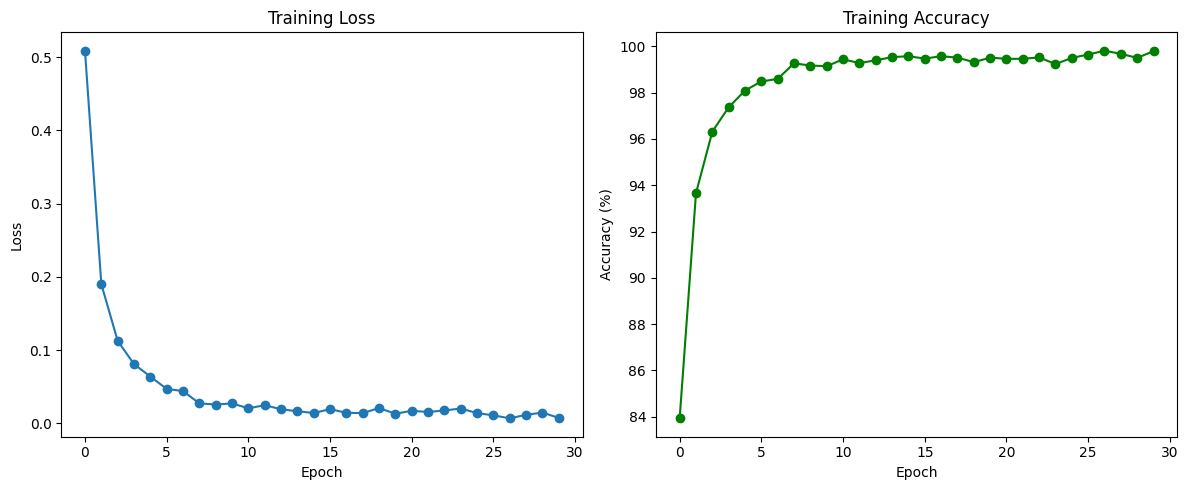

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
trained_cnn = train_model(model_cnn, train_loader, val_loader, num_epochs=30)


[Validation] Loss: 1.6497, Accuracy: 94.50%


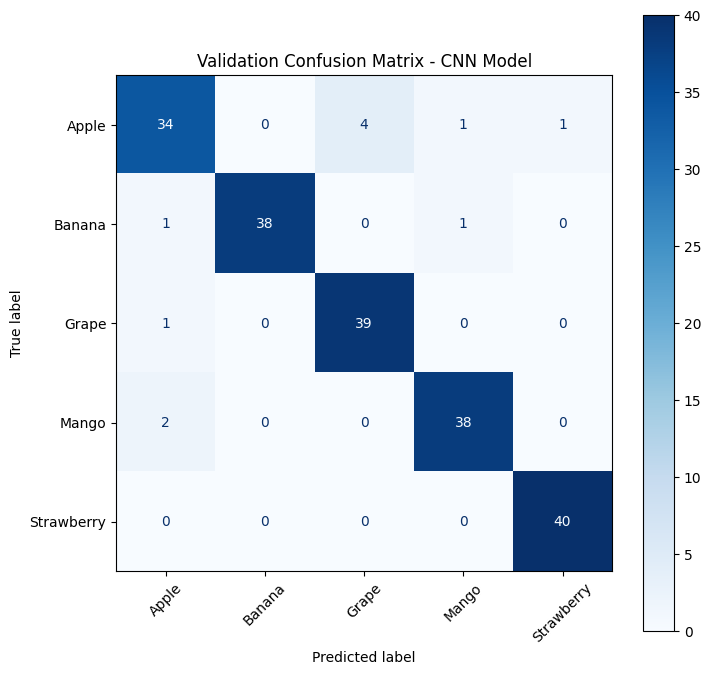


📊 Per-Class Accuracy:
  Apple: 85.00%
  Banana: 95.00%
  Grape: 97.50%
  Mango: 95.00%
  Strawberry: 100.00%

📋 Classification Report:
              precision    recall  f1-score   support

       Apple       0.89      0.85      0.87        40
      Banana       1.00      0.95      0.97        40
       Grape       0.91      0.97      0.94        40
       Mango       0.95      0.95      0.95        40
  Strawberry       0.98      1.00      0.99        40

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validate_model(trained_cnn, val_loader, criterion, device, class_names=class_names, name_model=" - CNN Model")

Epoch 1/30 - Loss: 0.3119 - Train Acc: 89.56%
Epoch 2/30 - Loss: 0.1912 - Train Acc: 93.65%
Epoch 3/30 - Loss: 0.1518 - Train Acc: 94.69%
Epoch 4/30 - Loss: 0.1181 - Train Acc: 95.95%
Epoch 5/30 - Loss: 0.1044 - Train Acc: 96.21%
Epoch 6/30 - Loss: 0.1024 - Train Acc: 96.66%
Epoch 7/30 - Loss: 0.0800 - Train Acc: 97.26%
Epoch 8/30 - Loss: 0.0723 - Train Acc: 97.52%
Epoch 9/30 - Loss: 0.0842 - Train Acc: 97.39%
Epoch 10/30 - Loss: 0.0630 - Train Acc: 97.90%
Epoch 11/30 - Loss: 0.0671 - Train Acc: 97.69%
Epoch 12/30 - Loss: 0.0633 - Train Acc: 97.97%
Epoch 13/30 - Loss: 0.0574 - Train Acc: 98.30%
Epoch 14/30 - Loss: 0.0663 - Train Acc: 97.87%
Epoch 15/30 - Loss: 0.0570 - Train Acc: 98.24%
Epoch 16/30 - Loss: 0.0595 - Train Acc: 97.92%
Epoch 17/30 - Loss: 0.0393 - Train Acc: 98.62%
Epoch 18/30 - Loss: 0.0667 - Train Acc: 97.73%
Epoch 19/30 - Loss: 0.0589 - Train Acc: 97.89%
Epoch 20/30 - Loss: 0.0516 - Train Acc: 98.32%
Epoch 21/30 - Loss: 0.0465 - Train Acc: 98.49%
Epoch 22/30 - Loss: 0.

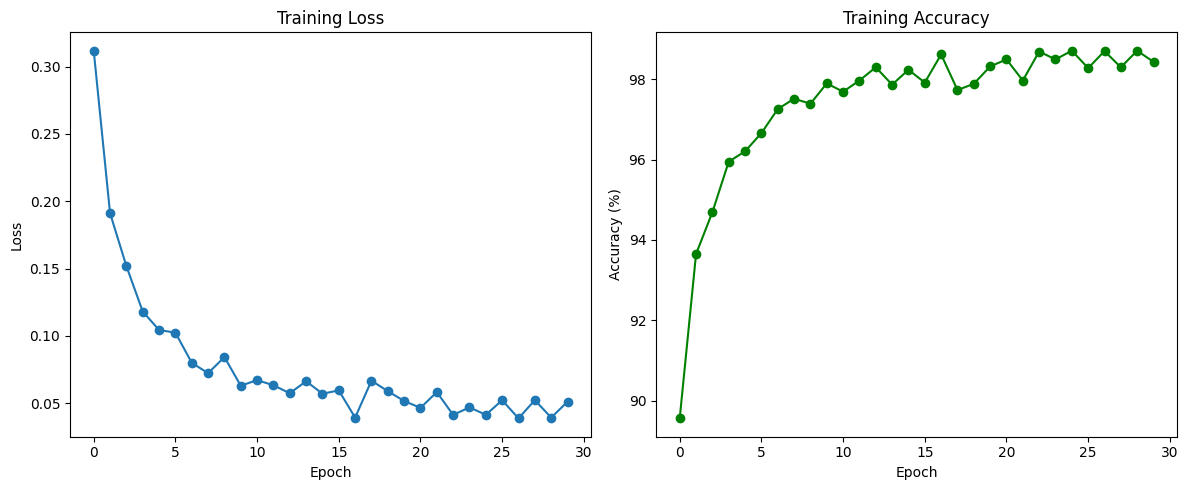

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
trained_vit = train_model(model_vit, train_loader, val_loader, num_epochs=30)


[Validation] Loss: 2.4560, Accuracy: 91.50%


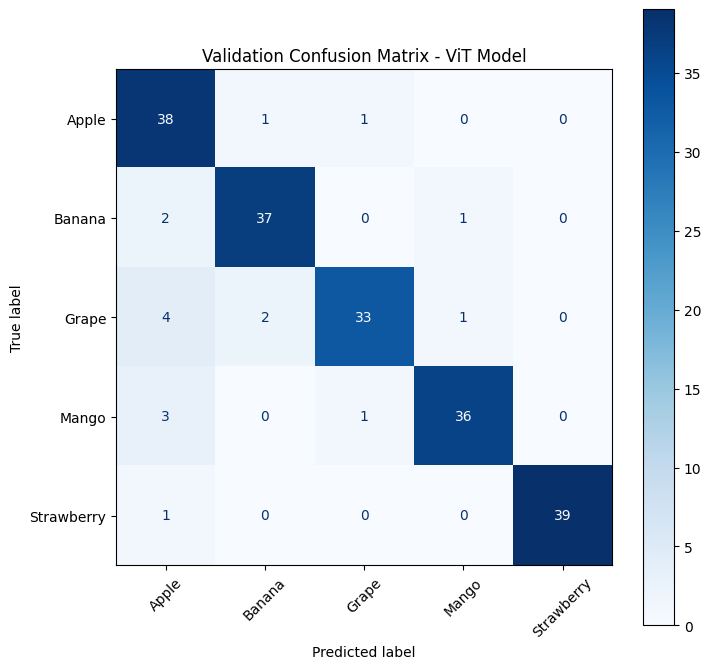


📊 Per-Class Accuracy:
  Apple: 95.00%
  Banana: 92.50%
  Grape: 82.50%
  Mango: 90.00%
  Strawberry: 97.50%

📋 Classification Report:
              precision    recall  f1-score   support

       Apple       0.79      0.95      0.86        40
      Banana       0.93      0.93      0.93        40
       Grape       0.94      0.82      0.88        40
       Mango       0.95      0.90      0.92        40
  Strawberry       1.00      0.97      0.99        40

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validate_model(trained_vit, val_loader, criterion, device, class_names=class_names, name_model=" - ViT Model" )